# HW 11
## James Camacho

We're solving the Helmholtz equation

$$u_{xx}+u_{yy} + k^2u = f(x,y).$$

We're given the exact solution

$$u(x, y) = j_0\left(k\sqrt{x^2+y^2}\right) + \cos(x) + \sin(y),$$

and that $j_0$ satisfies the homogenous equation.

### (a)

Let $v = \cos x + \sin y$. The principle of superposition gives

$$f = v_{xx} + v_{yy} + k^2v = (k^2-1)v = (k^2-1)(\cos x + \sin y).$$

The Dirichlet boundary conditions are

$$
\begin{align*}
u(x, 0) &= j_0(kx) + (k^2-1)\cos x,\\
u(0, y) &= j_0(ky) + (k^2-1)(1+\sin y),\\
u(x, 1) &= j_0\left(k\sqrt{x^2+1}\right) + (k^2-1)(\sin 1 + \cos x),\\
u(1, y) &= j_0\left(k\sqrt{y^2+1}\right) + (k^2-1)(\cos 1 + \sin y).
\end{align*}
$$

### (b)

I'm using `gmres` to solve the matrix problem rather than making an $n^2\times n^2$ matrix and solving for that. Also I'm using $k=10$.

In [13]:
import numpy as np
import functools
from scipy.sparse.linalg import LinearOperator, gmres
from scipy.special import jv
import scipy.sparse

j0 = lambda kr: jv(0, kr)


k = 20
def f(x, y):
    return (k**2 - 1)*(np.cos(x) + np.sin(y))

def u_exact(x, y):
    return j0(k*np.sqrt(x**2+y**2)) + np.cos(x) + np.sin(y)

@functools.lru_cache(maxsize=4)
def u_bdry(x, y, N):
    xi = np.linspace(0, 1, N)
    if x == None:
        return u_exact(xi, y)
    if y == None:
        return u_exact(x, xi)
    
    raise("Bad input. Example of good input: (None, 0) = along x axis with y=0.")

def add_boundaries(u, N):
    u = np.pad(u, pad_width=1, mode='empty').T
    u[0, :] = u_bdry(0, None, N)
    u[-1,:] = u_bdry(1, None, N)
    u[:, 0] = u_bdry(None, 0, N)
    u[:,-1] = u_bdry(None, 1, N)
    return u.T

def FivePoint(u):
    n = int(len(u)**0.5)
    u = u.reshape((n, n))
    n = len(u) + 1
    
    # Add Dirichlet boundaries.
    u = add_boundaries(u, n+1)
    
    # Compute second derivatives with 5 point stencil.
    uxx = n**2 * (u[2:, 1:-1] + u[0:-2, 1:-1] - 2*u[1:-1, 1:-1])
    uyy = n**2 * (u[1:-1, 2:] + u[1:-1, 0:-2] - 2*u[1:-1, 1:-1])
    k2u = k**2 * u[1:-1, 1:-1]
    
    return uxx + uyy + k2u

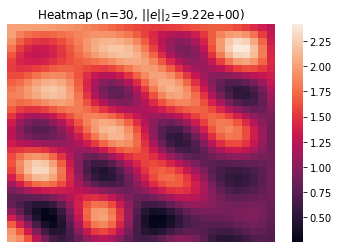

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

n = 30
A = LinearOperator((n**2, n**2), matvec=FivePoint)

x = np.linspace(0, 1, n+2)
y = np.linspace(0, 1, n+2)
xx, yy = np.meshgrid(x[1:-1], y[1:-1])
b = f(xx, yy).flatten()

u, _ = gmres(A, b)
u = u.reshape((n, n))
u = add_boundaries(u, n+2)


xx, yy = np.meshgrid(x, y)
ux = u_exact(xx, yy).reshape((n+2, n+2))
error = np.linalg.norm(u - ux)

plt.title(f"Heatmap (n={n}, $||e||_2$={error:.2e})")
ax = sns.heatmap(u)
ax.invert_yaxis()
plt.axis('off')
plt.show()

### (b)

Turns out it's a lot faster to build the sparse matrix and directly compute out the solution. Maybe because `gmres` isn't given a good initial guess? I don't know.

Here's the code for that:

In [46]:
def bdry(x, y, n):
    xi = np.linspace(0, 1, n+2)[1:-1]
    if x == None:
        return u_exact(xi, y)
    if y == None:
        return u_exact(x, xi)
    
    raise("Bad input. Example of good input: (None, 0) = along x axis with y=0.")

def get_F(n):
    xi = np.linspace(0, 1, n+2)[1:-1]
    x, y = np.meshgrid(xi, xi)
    F = f(x, y).reshape((n, n)).T / (n+1)**2
    
    # Subtract off Dirichlet boundaries
    F[0, :] -= bdry(0, None, n)
    F[-1, :] -= bdry(1, None, n)
    F[:, 0] -= bdry(None, 0, n)
    F[:, -1] -= bdry(None, 1, n)
    
    return F.T.flatten()

def get_A(n):
    d0 = np.full(n**2, (k/(n+1))**2 - 4)
    d1 = ([1]*(n-1) + [0])*n
    d2 = np.full(n**2, 1)
    diags = [d0, d1, d1, d2, d2]
    offsets = [0, 1, -1, n, -n]
    A = scipy.sparse.diags(diags, offsets, shape=(n**2,n**2))
    return A

def solve_helmholtz(n):
    A = get_A(n)
    F = get_F(n)
    u = scipy.sparse.linalg.spsolve(A, F)
    return u

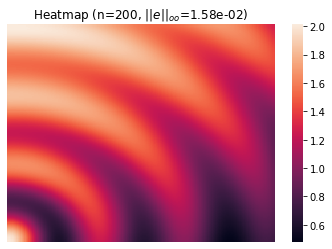

In [50]:
n = 200

u = solve_helmholtz(n)
u = u.reshape((n, n))
u = add_boundaries(u, n+2)

x = y = np.linspace(0, 1, n+2)
xx, yy = np.meshgrid(x, y)
ux = u_exact(xx, yy).reshape((n+2, n+2))
error = np.max(abs(u - ux))

plt.title(f"Heatmap (n={n}, $||e||_{{oo}}$={error:.2e})")
ax = sns.heatmap(u)
ax.invert_yaxis()
plt.axis('off')
plt.show()

In [51]:
errors = []
for n in [50, 100, 200, 400]:
    u = solve_helmholtz(n)
    u = u.reshape((n, n))
    u = add_boundaries(u, n+2)

    x = y = np.linspace(0, 1, n+2)
    xx, yy = np.meshgrid(x, y)
    ux = u_exact(xx, yy).reshape((n+2, n+2))
    error = np.max(abs(u - ux))
    errors.append(error)
print(errors)

[0.44925959919917435, 0.06674989175986412, 0.015825422345135953, 0.003930665284118673]
